In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def display_plot(image, title='', cmap=None):
    plt.imshow(image,cmap=cmap)
    plt.title(title)
    plt.show()

In [ ]:
def process_img(img, display=False):
    if display:
        display_plot(img,'Original image',None)


    #Convert to grayscale and denoise
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.fastNlMeansDenoising(img)
    if display:
        display_plot(img,'Grayscale and denoised','gray')


    #Histogram and percentile
    img_array = img.ravel()
    percentile = np.percentile(img_array,4)
    if display:
        plt.hist(img_array,256); 
        plt.show()
        print(percentile)


    #Find contours
    #1. Add binary threshold (here we use 50% of brightness as our threshold)
    ret, thresh = cv2.threshold(img, percentile, 255, 0)
    if display:
        display_plot(thresh,'With binary threshold applied','gray')

    #2. Find and draw contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #first contour is usually the whole image - remove it
    contours=contours[1:]
    img_contours = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)
    if display:
        display_plot(img_contours, 'Contours' , 'gray')


    #Find bounding boxes
    img_boxes = img.copy()
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(img_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    if display:
        display_plot(img_boxes,'Bounding boxes', 'gray')
    return img_boxes

## Test single image with intermediate steps displayed

In [ ]:
img = cv2.imread('equations/1.png')
process_img(img,display=True)

## Tests for whole set

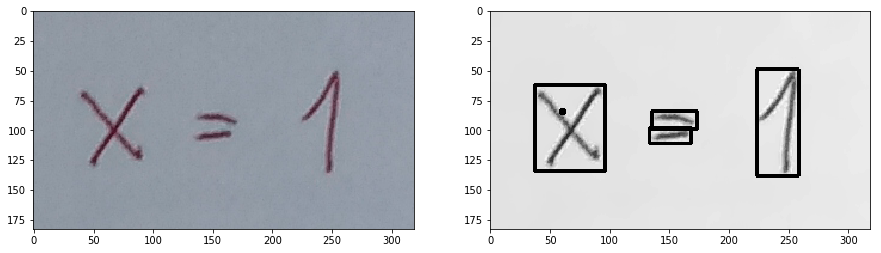

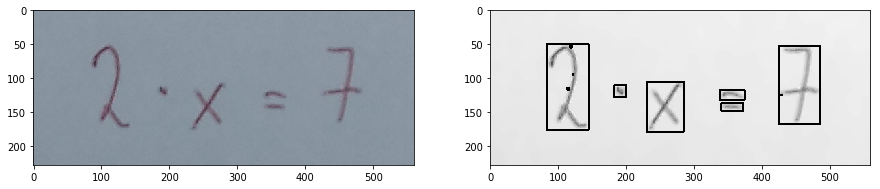

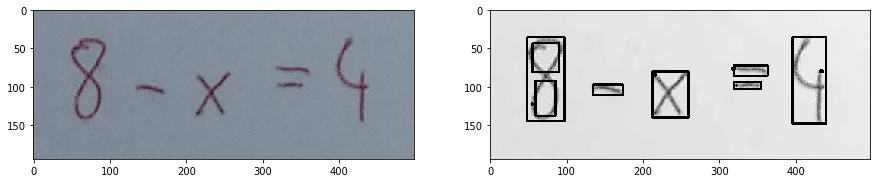

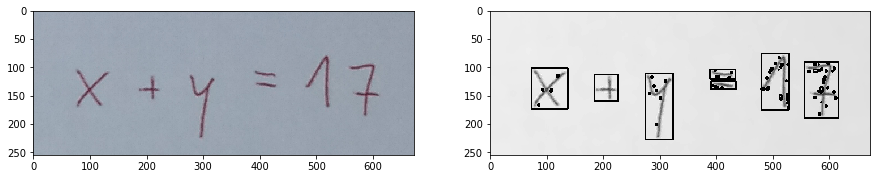

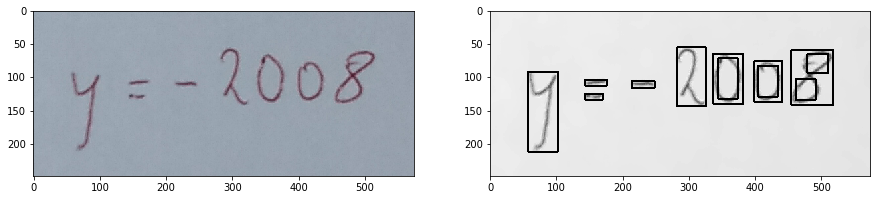

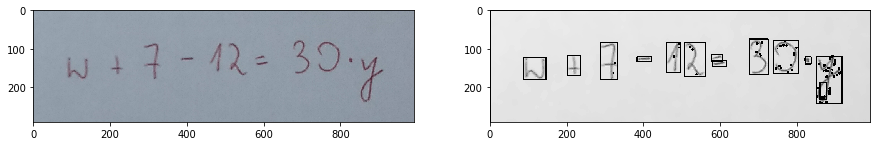

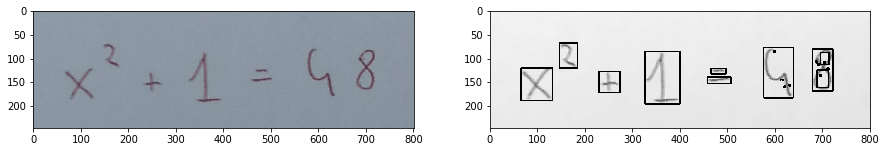

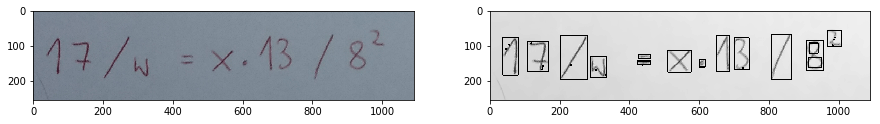

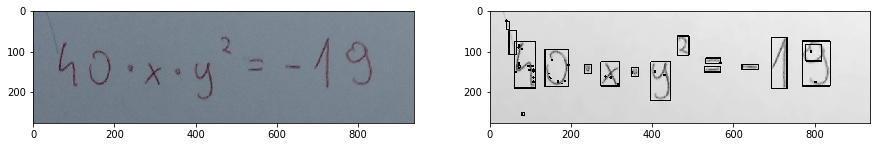

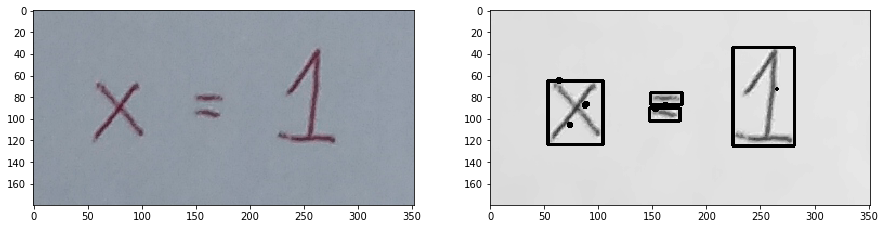

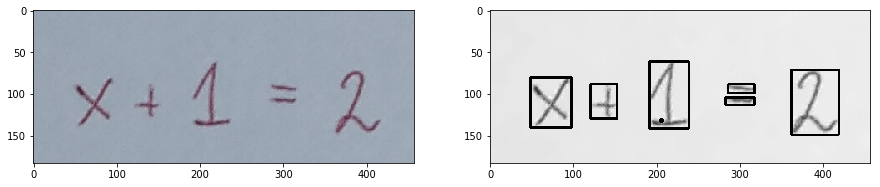

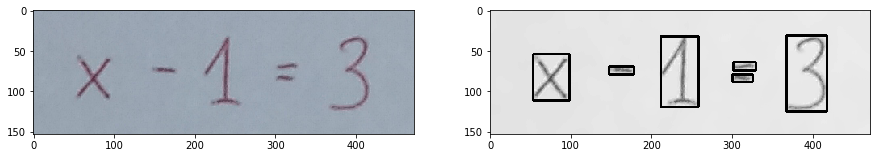

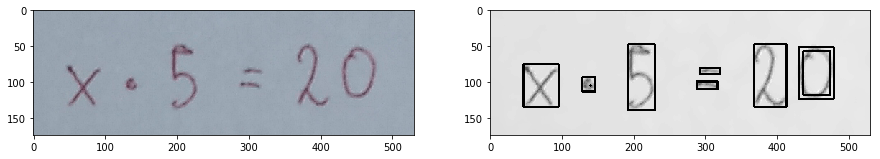

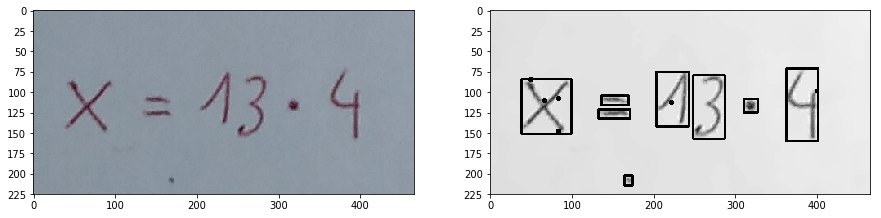

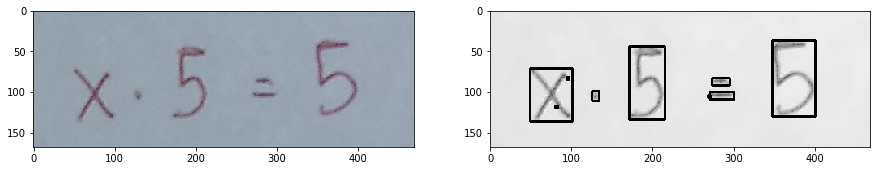

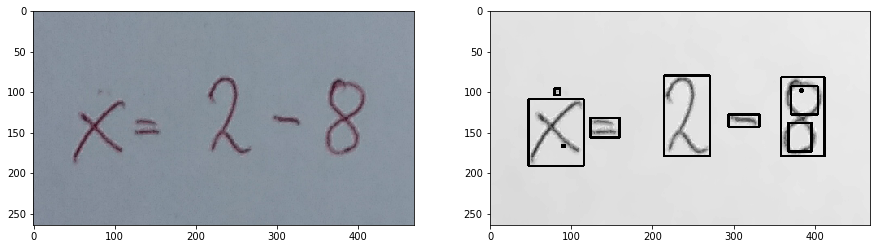

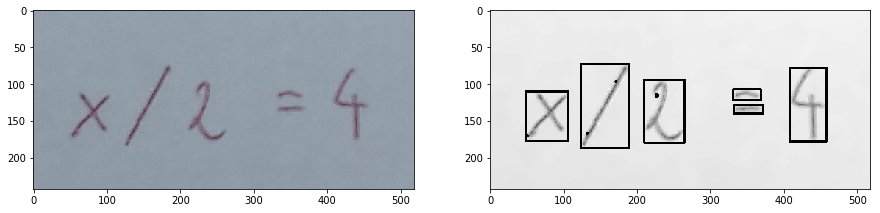

In [155]:
#Tests for whole set
DIR = 'equations'
for file in os.listdir(DIR):
    file=f'{DIR}/{file}'
    img = cv2.imread(file)
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    img_boxes = process_img(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_boxes, cmap='gray')
    plt.show()